<a href="https://colab.research.google.com/github/serg-kas/A-G-I-demo/blob/master/Model_VGG16_as_embeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analog Gauge Inspection

**Создание модели для определения показаний стрелочного прибора.**

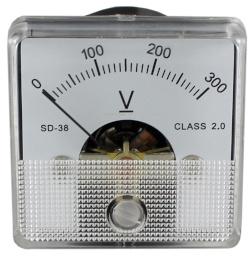

In [1]:
!git clone https://github.com/serg-kas/A-G-I-demo
%cd A-G-I-demo

Cloning into 'A-G-I-demo'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 105 (delta 56), reused 54 (delta 22), pack-reused 0
Receiving objects: 100% (105/105), 720.12 KiB | 8.37 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/A-G-I-demo


In [5]:
# Импорт библиотек
import numpy as np
import cv2 as cv
import os
import random
#
import utils as u 

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications.vgg16 import VGG16

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

Диапазон движение стрелки (0 справа): от 2.37 до 0.77
Случайное показание прибора: 119
Размер картинки: (175, 511, 3)


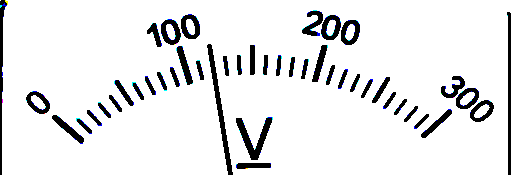

In [16]:
    # Подготовим изображение прибора (резайз и пр.)
    u.gauge_img_preparing()
    assert 'Voltmeter-Blank.jpg' in os.listdir('.')

    # Загружаем изображение прибора без стрелки
    img = cv.imread('Voltmeter-Blank.jpg')

    # Подготавливаем данные положения стрелки прибора
    # L - длинна стрелки
    # angle_0, angle_1  - углы крайних положений стрелки
    L, angle_0, angle_1 = u.gauge_needle_preparing(img)

    # Получаем случайное показание прибора
    img_example, r = u.get_random_measurement(img, L, angle_0, angle_1)
    print('Диапазон движение стрелки (0 справа): от {:.2f} до {:.2f}'.format(angle_0, angle_1))
    print('Случайное показание прибора: {}'.format(int(300 * (1 - r))))
    print('Размер картинки: {}'.format(img_example.shape))
    
    cv2_imshow(img_example)

**Подготовим выборку из 60 картинок (на шкале прибора 30 делений)**

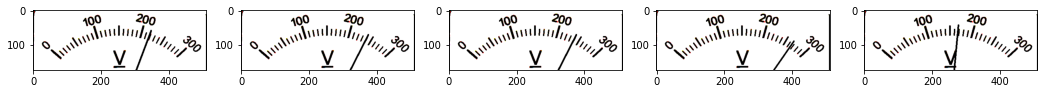

In [18]:
# Подготовим набор картинок в два раза больше делений шкалы.
img = cv.imread('Voltmeter-Blank.jpg')
angles = np.linspace(angle_1, angle_0, num=60)

images = []
for i in range(angles.shape[0]):
  angle = angles[i]
  # print(angle) 
  curr_img = img.copy()
  curr_img = u.get_angle_measurement(curr_img, L, angle)
  images.append(curr_img)

#
fig, axs = plt.subplots(1, 5, figsize=(18, 5))                      
for i in range(5):                                                 
    plot_img = random.choice(images)     
    axs[i].imshow(plot_img)
plt.show() 

**Модель на базе VGG16**

In [ ]:
# скачиваем модель
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
# дополняем модель
x = base_model.output
# x = Dropout(0.5)(x)                          
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)        
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)         
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
# 
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
# Функция  - генератор данных
def generate_data(batchsize):
    x_data = []
    y_data = []
    batchcount = 0
    while True:
        curr_img, curr_r = u.get_random_measurement(img, L, angle_0, angle_1)
        curr_img = cv.resize(curr_img, (224, 224), cv.INTER_LINEAR)
        curr_img = curr_img / 255.
        x_data.append(curr_img)
        y_data.append(curr_r)
        batchcount += 1
        if batchcount >= batchsize:
            X = np.array(x_data, dtype='float32')
            y = np.array(y_data, dtype='float32')
            # print(X.shape, y.shape)
            yield (X, y)
            x_data = []
            y_data = []
            batchcount = 0


**Посмотрим предикт**

In [ ]:
# model = load_model('base-model-CNN.h5')
img = cv.imread('Voltmeter-Blank.jpg')
L, angle_0, angle_1 = u.gauge_needle_preparing(img)

N = 10
# fig, axs = plt.subplots(1, N, figsize=(18, 5))
for i in range(N):
  curr_img, curr_r = u.get_random_measurement(img, L, angle_0, angle_1)
  # подготовим изображение для отправки в модель
  img_to_pred = np.array(curr_img)
  img_to_pred = cv.resize(img_to_pred, (224, 224), cv.INTER_LINEAR)
  img_to_pred = img_to_pred / 255. 
  img_to_pred = np.expand_dims(img_to_pred, axis = 0)
  pred = model.predict(img_to_pred)[0]
  print("Значение: {:.2f}, предикт {:.2f}".format(curr_r, pred[0]))
  


Значение: 0.23, предикт 0.43
Значение: 0.12, предикт 0.44
Значение: 0.00, предикт 0.45
Значение: 0.38, предикт 0.46
Значение: 0.54, предикт 0.47
Значение: 0.76, предикт 0.47
Значение: 0.93, предикт 0.46
Значение: 0.64, предикт 0.48
Значение: 0.51, предикт 0.50
Значение: 0.86, предикт 0.51
